# 61 Exporting Geological Maps and Custom sections from GemPy

## Set File Paths and download Tutorial Data

If you downloaded the latest `GemGIS` version from the Github repository, append the path so that the package can be imported successfully. Otherwise, it is recommended to install `GemGIS` via `pip install gemgis` and import `GemGIS` using `import gemgis as gg`. In addition, the file path to the folder where the data is being stored is set. The tutorial data is downloaded using Pooch (https://www.fatiando.org/pooch/latest/index.html) and stored in the specified folder. Use `pip install pooch` if Pooch is not installed on your system yet.

<img src="../images/tutorial61_cover.png"> 

In [22]:
import gemgis as gg

file_path ='data/61_Exporting_geological_map_and_custom_sections_from_GemPy/'
gg.download_gemgis_data.download_tutorial_data(filename="61_Exporting_geological_map_and_custom_sections_from_GemPy.zip", dirpath=file_path)

## Loading the data

In [23]:
import geopandas as gpd
import rasterio

interfaces = gpd.read_file(file_path + 'interfaces.shp')
orientations = gpd.read_file(file_path + 'orientations.shp')
extent = [0,972,0,1069, 300, 800]
resolution = [50, 50, 50]

In [24]:
interfaces.head()

,level_0,level_1,formation,X,Y,Z,geometry
0,0,0,Sand1,0.26,264.86,353.97,POINT (0.25633 264.86215)
1,0,0,Sand1,10.59,276.73,359.04,POINT (10.59347 276.73371)
2,0,0,Sand1,17.13,289.09,364.28,POINT (17.13494 289.08982)
3,0,0,Sand1,19.15,293.31,364.99,POINT (19.15013 293.31349)
4,0,0,Sand1,27.80,310.57,372.81,POINT (27.79512 310.57169)


In [25]:
orientations['polarity'] = 1
orientations.head()

,formation,dip,azimuth,X,Y,Z,geometry,polarity
0,Ton,30.50,180.00,96.47,451.56,477.73,POINT (96.47104 451.56362),1
1,Ton,30.50,180.00,172.76,661.88,481.73,POINT (172.76101 661.87650),1
2,Ton,30.50,180.00,383.07,957.76,444.45,POINT (383.07389 957.75787),1
3,Ton,30.50,180.00,592.36,722.70,480.57,POINT (592.35583 722.70229),1
4,Ton,30.50,180.00,766.59,348.47,498.96,POINT (766.58562 348.46907),1


## Creating the GemPy Model

In [26]:
import sys
sys.path.append('../../../../gempy-master')
import gempy as gp

In [27]:
geo_model = gp.create_model('Model1')
geo_model

Model1  2023-05-08 12:52

### Initiating the Model

In [28]:
import pandas as pd

gp.init_data(geo_model, extent, resolution,
             surface_points_df = interfaces,
             orientations_df = orientations,
             default_values=True)
geo_model.surfaces

Active grids: ['regular']


,surface,series,order_surfaces,color,id
0,Sand1,Default series,1,#015482,1
1,Ton,Default series,2,#9f0052,2


The vertices and edges are currently NaN values, so no model has been computed so far.

In [29]:
geo_model.surfaces.df

,surface,series,order_surfaces,isBasement,isFault,isActive,hasData,color,vertices,edges,sfai,id
0,Sand1,Default series,1,False,False,True,True,#015482,NaN,NaN,NaN,1
1,Ton,Default series,2,True,False,True,True,#9f0052,NaN,NaN,NaN,2


### Mapping Stack to Surfaces

In [30]:
gp.map_stack_to_surfaces(geo_model,
                         {"Strat_Series": ('Sand1', 'Ton')},
                         remove_unused_series=True)
geo_model.add_surfaces('basement')

,surface,series,order_surfaces,color,id
0,Sand1,Strat_Series,1,#015482,1
1,Ton,Strat_Series,2,#9f0052,2
2,basement,Strat_Series,3,#ffbe00,3


### Loading the Topography

In [31]:
geo_model.set_topography(
    source='gdal', filepath='data/61_Exporting_geological_map_and_custom_sections_from_GemPy/raster1.tif')

Cropped raster to geo_model.grid.extent.
depending on the size of the raster, this can take a while...
storing converted file...
Active grids: ['regular' 'topography']


Grid Object. Values: 
array([[   9.72      ,   10.69      ,  305.        ],
       [   9.72      ,   10.69      ,  315.        ],
       [   9.72      ,   10.69      ,  325.        ],
       ...,
       [ 970.056     , 1059.28181818,  622.0892334 ],
       [ 970.056     , 1063.16909091,  622.06713867],
       [ 970.056     , 1067.05636364,  622.05786133]])

### Defining Custom Section

In [32]:
custom_section = gpd.read_file(file_path + 'customsections1.shp')
custom_section_dict = gg.utils.to_section_dict(custom_section, section_column='section')
geo_model.set_section_grid(custom_section_dict)

Active grids: ['regular' 'topography' 'sections']


,start,stop,resolution,dist
Section1,"[1.372395262185787, 383.9794474025771]","[970.9954955186289, 383.8831909730347]","[100, 80]",969.62


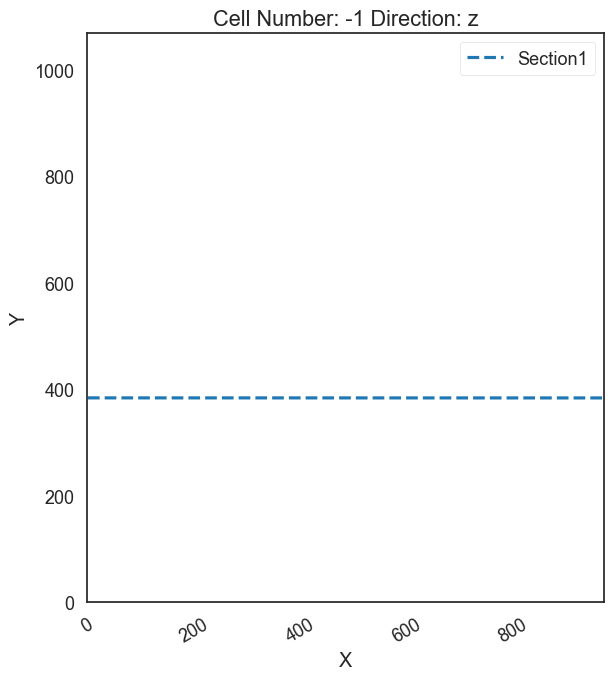

In [33]:
gp.plot.plot_section_traces(geo_model)

### Setting Interpolator

In [34]:
gp.set_interpolator(geo_model,
                    compile_theano=True,
                    theano_optimizer='fast_compile',
                    verbose=[],
                    update_kriging = False
                    )

Compiling theano function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!
Kriging values: 
                   values
range            1528.90
$C_o$           55655.83
drift equations      [3]


### Computing Model

In [35]:
sol = gp.compute_model(geo_model, compute_mesh=True)

The surfaces DataFrame now contains values for vertices and edges.

In [36]:
geo_model.surfaces.df

,surface,series,order_surfaces,isBasement,isFault,isActive,hasData,color,vertices,edges,sfai,id
0,Sand1,Strat_Series,1,False,False,True,True,#015482,"[[29.160000000000004, 194.27877317428587, 305....","[[2, 1, 0], [2, 0, 3], [3, 4, 2], [2, 4, 5], [...",0.26,1
1,Ton,Strat_Series,2,False,False,True,True,#9f0052,"[[29.160000000000004, 365.78652999877926, 305....","[[2, 1, 0], [2, 0, 3], [3, 4, 2], [2, 4, 5], [...",0.21,2
2,basement,Strat_Series,3,True,False,True,True,#ffbe00,NaN,NaN,NaN,3


## Plotting the 3D Model

C:\Users\jan13846\.conda\envs\gemgis\lib\site-packages\pyvista\plotting\tools.py:571: PyvistaDeprecationWarning: The usage of `parse_color` is deprecated in favor of the new `Color` class.
  warnings.warn(
C:\Users\jan13846\.conda\envs\gemgis\lib\site-packages\pyvista\jupyter\notebook.py:60: UserWarning: Failed to use notebook backend: 

Please install `ipyvtklink` to use this feature: https://github.com/Kitware/ipyvtklink

Falling back to a static output.
  warnings.warn(


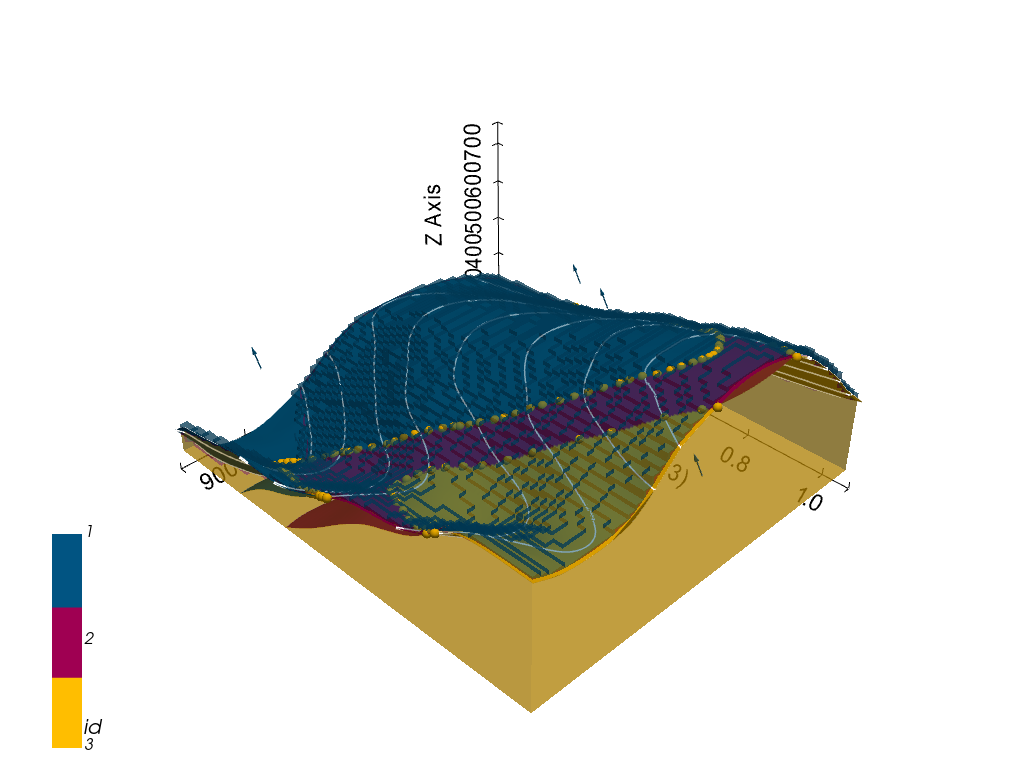

In [37]:
gpv = gp.plot_3d(geo_model, image=False, show_topography=True,
                 plotter_type='basic', notebook=True, show_lith=True)

## Extracting Shapefiles from Gempy model

Using the following code we are able to download the custom sections and the geological map as shapefiles

### Extracting GemPy Section Lines as Shapefiles

In [38]:
from shapely.geometry import LineString
gdf_sections = geo_model.grid.sections.df.copy(deep=True)
gdf_sections.reset_index()
linestrings = [LineString((gdf_sections.iloc[i]['start'],gdf_sections.iloc[i]['stop'] )) for i in range(len(gdf_sections))]
gdf_sections_new = gpd.GeoDataFrame(geometry=linestrings, data= gdf_sections.reset_index()[['index']], crs='EPSG:32632')
gdf_sections_new.to_file(file_path + 'test_sections.shp')

### Extracting GemPy Geological Map Polygons as Shapefiles

In [39]:
gdf = gg.postprocessing.extract_lithologies(geo_model, geo_model.grid.regular_grid.extent[:4], crs='EPSG:32632')
gdf.to_file(file_path + 'test.shp')

<img src="../images/Extracted_Files_QGIS.png" width=700>